### Dicionário de Dados

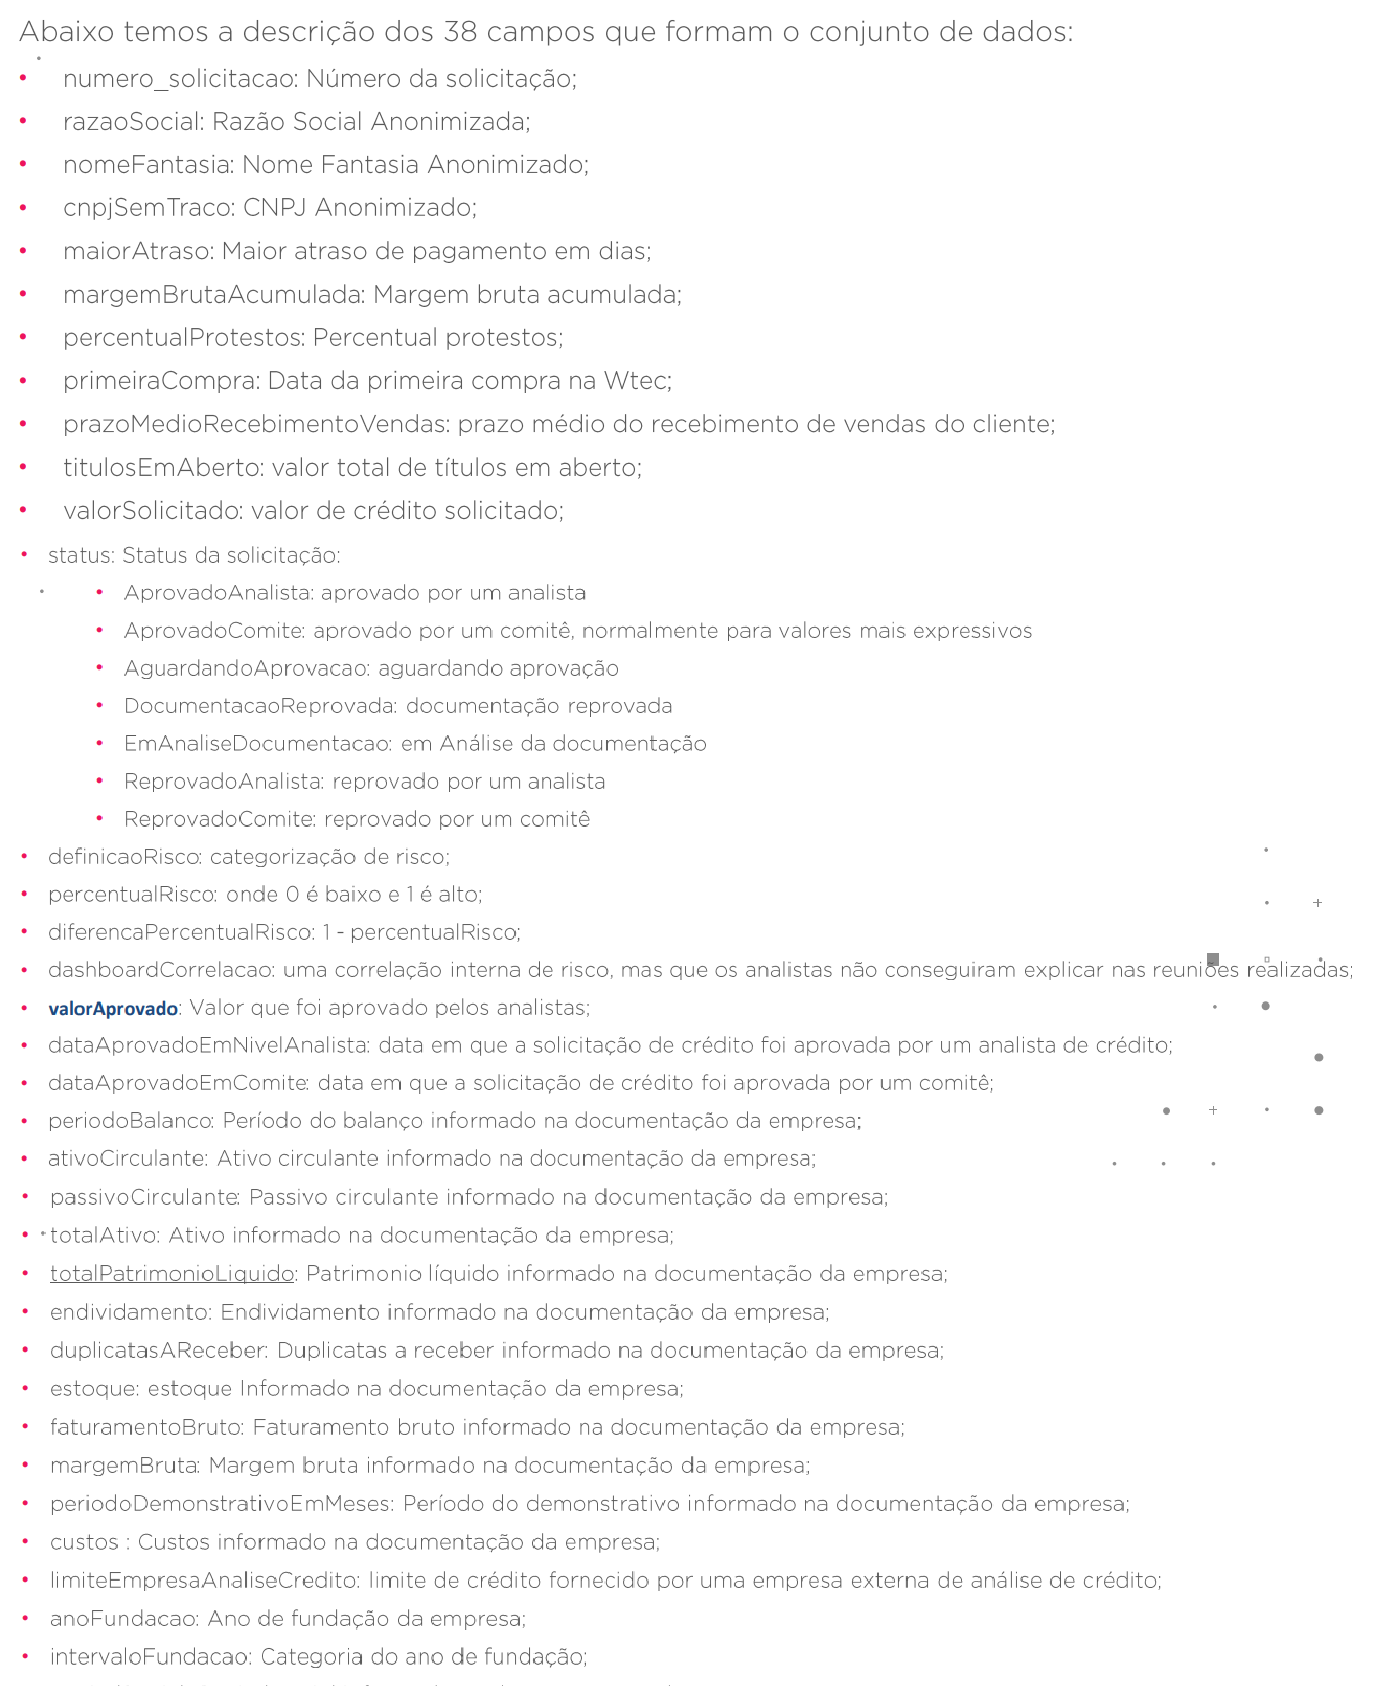

## Lógica usada neste trabalho
Existem dois problemas principais neste dataset:
    - Muitos nulos
    - Algumas variáveis não são 'inputáveis'
    - Alta correlação entre colunas
Portanto, será necessário realizar uma redução de dimensionalidade, primeiramente em colunas que sejam resultados calculados de análises feitas fora do escopo deste trabalho.

### Fluxo:
1. Redução da dimensionalidade em colunas que expressem dados de outros processos
2. Feature engineering 
3. Análise de colunas categóricas
4. Tratamento de nulos
5. Validação de feature importance
6. Redução de dimensionalidade com base na feature importance (para modelo preditivo)
7. Segmentação do dataframe
8. Análise de características dos clusters
9. Modelos preditivos por cluster


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json
import warnings
warnings.filterwarnings("ignore")

In [45]:
#carregando dicionário de dados
with open ('descricao_colunas.json', 'r') as jsonfile:
    dict_desc_colunas = json.load(jsonfile)
for item in dict_desc_colunas:
    print (item+':', dict_desc_colunas[item])

numero_solicitacao: Número da solicitação
razaoSocial: Razão Social Anonimizada
nomeFantasia: Nome Fantasia Anonimizado
cnpjSemTraco: CNPJ Anonimizado
maiorAtraso: Maior atraso de pagamento em dias
margemBrutaAcumulada: Margem bruta acumulada
percentualProtestos: Percentual protestos
primeiraCompra: Data da primeira compra na Wtec
prazoMedioRecebimentoVendas: prazo médio do recebimento de vendas do cliente
titulosEmAberto: valor total de títulos em aberto
valorSolicitado: valor de crédito solicitado
status: Status da solicitação
definicaoRisco: categorização de risco
percentualRisco: onde O é baixo e 1 é alto
diferencaPercentualRisco: 1- percentual Risco
dashboardCorrelacao: uma correlação interna de risco, mas que os analistas não conseguiram explicar nas reuniões realizadas
valorAprovado: Valor que foi aprovado pelos analistas
dataAprovadoNivelAnalista: data em que a solicitação de crédito foi aprovada por um analista de crédito
dataAprovadoEmComite: data em que a solicitação de créd

In [141]:
print ('Porcentagem de valores cedidos em relação a solicitados:',
       round((df['valorAprovado']/df['valorSolicitado']).mean(),2))

Porcentagem de valores cedidos em relação a solicitados: 0.7


In [41]:
df = pd.read_csv('bootcamp-solicitacoescredito.csv')
pd.set_option('display.max_columns', df.shape[1])
pd.set_option('display.max_rows', 50)

df

,numero_solicitacao,razaoSocial,nomeFantasia,cnpjSemTraco,maiorAtraso,margemBrutaAcumulada,percentualProtestos,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,status,definicaoRisco,diferencaPercentualRisco,percentualRisco,dashboardCorrelacao,valorAprovado,dataAprovadoEmComite,periodoBalanco,ativoCirculante,passivoCirculante,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,estoque,faturamentoBruto,margemBruta,periodoDemonstrativoEmMeses,custos,anoFundacao,intervaloFundacao,capitalSocial,restricoes,empresa_MeEppMei,scorePontualidade,limiteEmpresaAnaliseCredito,dataAprovadoNivelAnalista
0,1,James Richardson-Patel,Alexandra Williams,KEBE17609492220843,0,0.252448,0.0,2015-12-10T00:00:00,0,0.00,50000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.716981,0.283019,0.000000,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1766880.0,0.0,12.0,0.0,2003.0,Acima de 17 anos,90000.0,False,True,1.000000,43200.0,2020-02-03T20:57:33
1,2,Dr. Geoffrey Walsh,Mr. Darren Arnold,JRBK88908250677300,0,0.000000,NaN,2019-06-12T17:28:31,0,0.00,10000.0,DocumentacaoReprovada,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,3,Joanna Hudson,Dr. David Rees,GCVQ28531614261293,4,0.624777,0.0,2019-11-27T00:00:00,0,0.00,20000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.716981,0.283019,0.000000,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2814940.0,0.0,7.0,0.0,2014.0,De 6 a 10 anos,20000.0,False,True,1.000000,4320.0,2020-02-04T16:40:49
3,4,Gordon Jones-Hopkins,Sara Reid-Robson,KJND32266018316396,20,0.000000,NaN,2017-02-13T17:20:27,0,0.00,25000.0,AprovadoAnalista,De 51 a 80 % - Alto,0.396226,0.603774,0.485811,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1285274.0,0.0,12.0,0.0,2013.0,De 6 a 10 anos,30000.0,False,True,0.000000,5920.0,2020-02-04T16:37:52
4,5,Nigel Lee,Dr. Stanley Duncan,CGQN15826802440348,20,0.454088,0.0,2010-07-13T00:00:00,20,1486.95,50000.0,AprovadoAnalista,De 11 a 30 % - Baixo,0.830189,0.169811,0.000000,50000.0,NaN,2019-09-30T00:00:00,14758917.0,12149031.0,25793410.0,14544378.0,3039112.0,11797928.0,3047791.0,40779757.0,81459809.0,9.0,40680051.0,2002.0,Acima de 17 anos,75000.0,False,False,1.000000,89000.0,2020-02-04T15:06:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,9041,Leah Williams,Georgia Booth,YKGZ02907098931653,149,0.306580,0.0,2006-04-26T00:00:00,59,599964.04,900000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990876,NaN,NaN
8969,9042,Mr. Jordan Stevens,Miss Ellie Kelly,UCBM91111020900951,23,0.329796,0.0,2016-08-03T00:00:00,0,0.00,150000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958869,NaN,NaN
8970,9043,Mr. Barry Wells,Danielle Hudson,CLDB61185288622179,3,0.383919,0.0,2018-10-25T00:00:00,4,2933.38,150000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
8971,9044,Keith Jones,Steven Kennedy-Jones,BRJP37453437154592,11,0.424099,0.0,2011-08-10T00:00:00,31,559679.98,1290000.0,EmAnaliseDocumentacao,De 0 a 10 % - Muito Baixo,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.994786,NaN,NaN


### reduzindo dimensionalidade de negócios
##### dados externos e cadastrais
Dropar:
* numero_solicitacao
* razaoSocial
* nomeFantasia
* maiorAtraso
* margemBrutaAcumulada
* percentualProtestos
* status
* definicaoRisco
* diferencaPercentualRisco
* percentualRisco
* dashboardCorrelacao
* dataAprovadoEmComite
* anoFundacao - existe coluna categórica intervaloFundacao que permitiria segmentacao
* restricoes
* scorePontualidade
* limiteEmpresaAnaliseCredito
* dataAprovadoNivelAnalista
* dataAprovadoNivelAnalista

In [55]:
df = pd.read_csv('bootcamp-solicitacoescredito.csv')
a_dropar = [
            'numero_solicitacao',
            'razaoSocial',
            'nomeFantasia',
            'maiorAtraso',
            'margemBrutaAcumulada',
            'percentualProtestos',
            'status',
            'definicaoRisco',
            'diferencaPercentualRisco',
            'percentualRisco',
            'dashboardCorrelacao',
            'dataAprovadoEmComite',
            'anoFundacao',
            'restricoes',
            'scorePontualidade',
            'limiteEmpresaAnaliseCredito',
            'dataAprovadoNivelAnalista',
            'dataAprovadoNivelAnalista'
            ]

for col in sorted(a_dropar):
    print ('DROP '+col+' --  ' + dict_desc_colunas[col])

df = df.drop(columns=a_dropar)

DROP anoFundacao --  Ano de fundação da empresa
DROP dashboardCorrelacao --  uma correlação interna de risco, mas que os analistas não conseguiram explicar nas reuniões realizadas
DROP dataAprovadoEmComite --  data em que a solicitação de crédito foi aprovada por um comitê
DROP dataAprovadoNivelAnalista --  data em que a solicitação de crédito foi aprovada por um analista de crédito
DROP dataAprovadoNivelAnalista --  data em que a solicitação de crédito foi aprovada por um analista de crédito
DROP definicaoRisco --  categorização de risco
DROP diferencaPercentualRisco --  1- percentual Risco
DROP limiteEmpresaAnaliseCredito --  limite de crédito fornecido por uma empresa externa de análise de crédito
DROP maiorAtraso --  Maior atraso de pagamento em dias
DROP margemBrutaAcumulada --  Margem bruta acumulada
DROP nomeFantasia --  Nome Fantasia Anonimizado
DROP numero_solicitacao --  Número da solicitação
DROP percentualProtestos --  Percentual protestos
DROP percentualRisco --  onde O é 

In [54]:
# observando df após drop
df

,cnpjSemTraco,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,valorAprovado,periodoBalanco,ativoCirculante,passivoCirculante,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,estoque,faturamentoBruto,margemBruta,periodoDemonstrativoEmMeses,custos,intervaloFundacao,capitalSocial,empresa_MeEppMei
0,KEBE17609492220843,2015-12-10T00:00:00,0,0.00,50000.0,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1766880.0,0.0,12.0,0.0,Acima de 17 anos,90000.0,True
1,JRBK88908250677300,2019-06-12T17:28:31,0,0.00,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GCVQ28531614261293,2019-11-27T00:00:00,0,0.00,20000.0,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2814940.0,0.0,7.0,0.0,De 6 a 10 anos,20000.0,True
3,KJND32266018316396,2017-02-13T17:20:27,0,0.00,25000.0,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1285274.0,0.0,12.0,0.0,De 6 a 10 anos,30000.0,True
4,CGQN15826802440348,2010-07-13T00:00:00,20,1486.95,50000.0,50000.0,2019-09-30T00:00:00,14758917.0,12149031.0,25793410.0,14544378.0,3039112.0,11797928.0,3047791.0,40779757.0,81459809.0,9.0,40680051.0,Acima de 17 anos,75000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,YKGZ02907098931653,2006-04-26T00:00:00,59,599964.04,900000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8969,UCBM91111020900951,2016-08-03T00:00:00,0,0.00,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8970,CLDB61185288622179,2018-10-25T00:00:00,4,2933.38,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8971,BRJP37453437154592,2011-08-10T00:00:00,31,559679.98,1290000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Alta Correlação
Verificando a possibilidade de dropar colunas com alta correlação, reduzindo o dataset.

ρ = 0,9 a 1 (positivo ou negativo): correlação muito forte;

ρ = 0,7 a 09 (positivo ou negativo): correlação forte;

ρ = 0,5 a 0,7 (positivo ou negativo): correlação moderada;

ρ = 0,3 a 0,5 (positivo ou negativo): correlação fraca;

ρ = 0 a 0,3 (positivo ou negativo): não possui correlação.

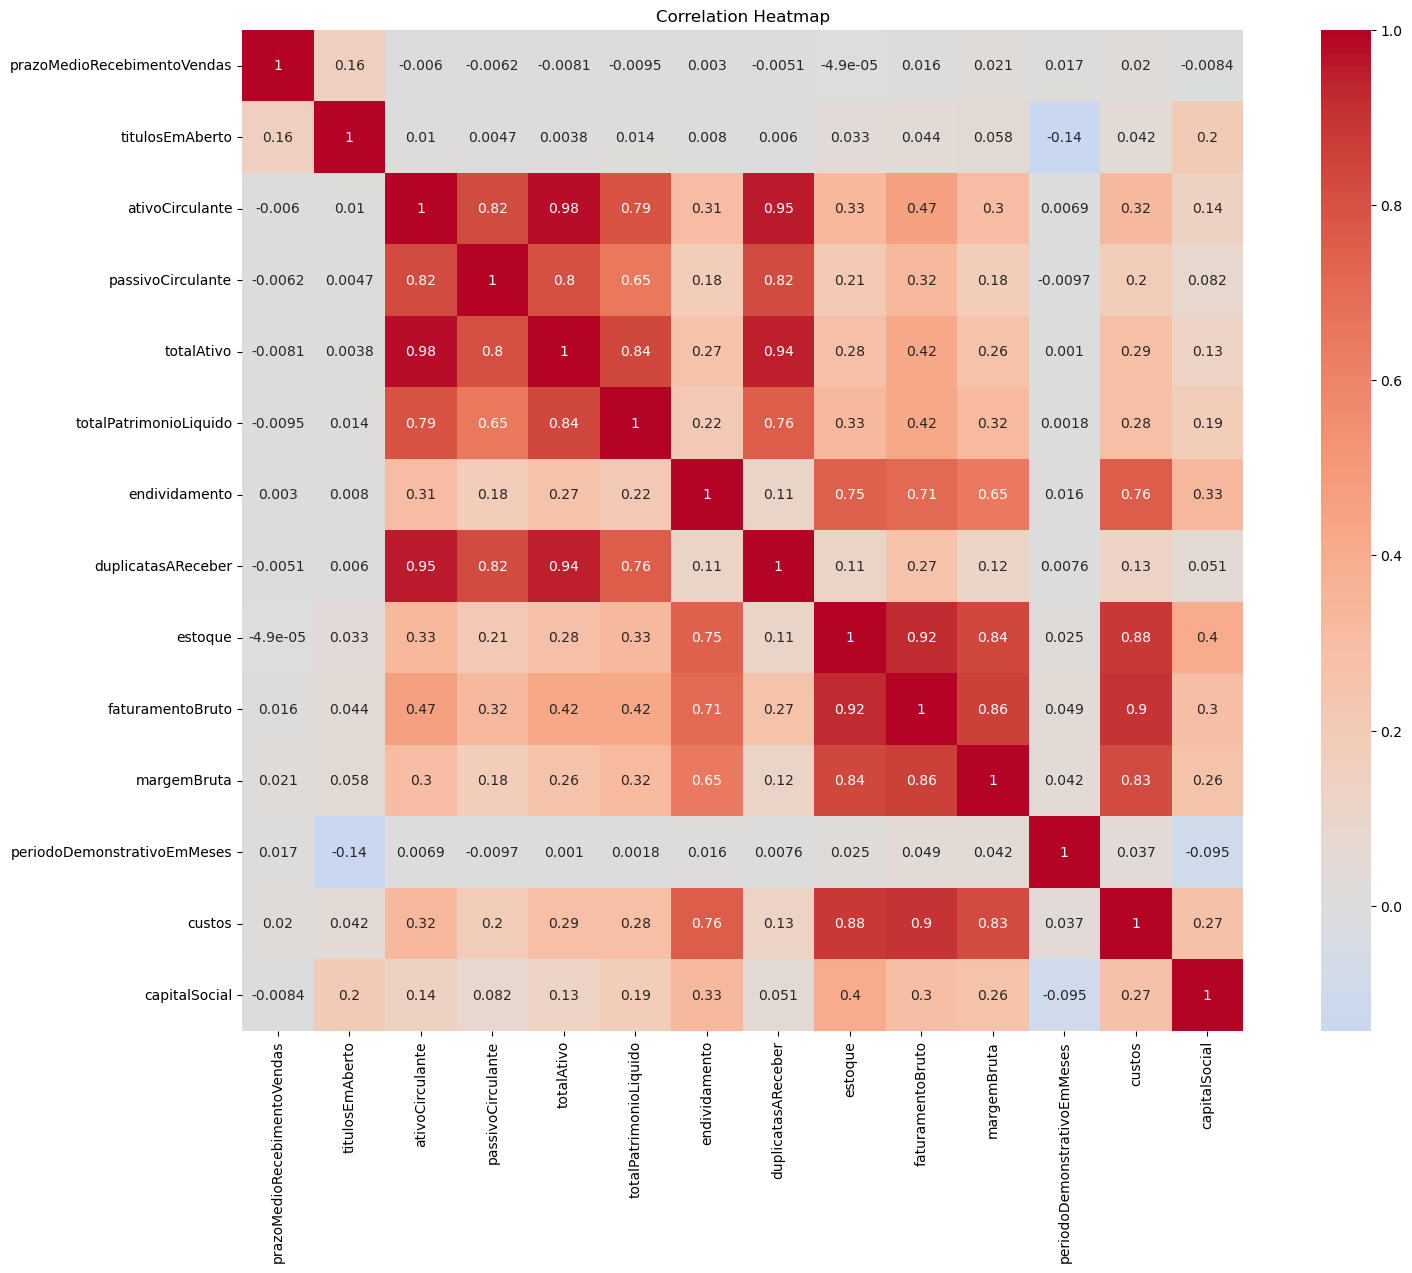

In [56]:
#verificando alta correlação em variáveis independentes
# dropando valorSolicitado da análise por ser dado de entrada muito importante

corr_matrix = df.drop(columns=['valorSolicitado','valorAprovado']).corr() 
plt.figure(figsize=(20, 13))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap')
plt.show()


In [86]:
#maiores correlacões entre todas as colunas, quando correlação for importante porém abaixo de 1
corr_matrix[((corr_matrix>0.5) & (corr_matrix<1) | ((corr_matrix>-1) & (corr_matrix<-0.5)))]\
            .sum()\
            .sort_values(ascending = False)

totalAtivo                     3.569262
ativoCirculante                3.540519
duplicatasAReceber             3.482461
estoque                        3.395407
faturamentoBruto               3.394113
custos                         3.368337
margemBruta                    3.172569
passivoCirculante              3.101556
totalPatrimonioLiquido         3.041779
endividamento                  2.865497
prazoMedioRecebimentoVendas    0.000000
titulosEmAberto                0.000000
periodoDemonstrativoEmMeses    0.000000
capitalSocial                  0.000000
dtype: float64

Notamos acima muitas colunas com alta correlação. Veremos quais são.

In [117]:
#buscando maiores correlações
colunas_alta_correlacao = {}
for row_idx, row in corr_matrix.iterrows():
    dict_row = {}
    for col in corr_matrix.columns:
        if col != row_idx:
            dict_row.update({row[col]:col})
    score_correlacao_ascendente = []
    for corr_score in sorted(dict_row, reverse=True):
        score_correlacao_ascendente.append(dict_row[corr_score])
    colunas_alta_correlacao.update({row_idx:score_correlacao_ascendente})
df_correlacao_ordenada = pd.DataFrame.from_dict(colunas_alta_correlacao).T
df_correlacao_ordenada = df_correlacao_ordenada[[0,1,2]]
df_correlacao_ordenada.sort_index(inplace=True)
df_correlacao_ordenada.columns = ['maior', 'segunda_maior', 'terceira_maior']
df_correlacao_ordenada

,maior,segunda_maior,terceira_maior
ativoCirculante,totalAtivo,duplicatasAReceber,passivoCirculante
capitalSocial,estoque,endividamento,faturamentoBruto
custos,faturamentoBruto,estoque,margemBruta
duplicatasAReceber,ativoCirculante,totalAtivo,passivoCirculante
endividamento,custos,estoque,faturamentoBruto
estoque,faturamentoBruto,custos,margemBruta
faturamentoBruto,estoque,custos,margemBruta
margemBruta,faturamentoBruto,estoque,custos
passivoCirculante,duplicatasAReceber,ativoCirculante,totalAtivo
periodoDemonstrativoEmMeses,faturamentoBruto,margemBruta,custos


Vemos então que faz sentido dropar mais colunas, visto que as informações em uma podem estar representadas também em outras.

Vamos então dropar as seguintes:
ativoCirculante - parece estar melhor representada pelo totalAtivo
estoque - tem alta correlação com capitalSocial e faturamentoBruto
custos - tem alta correlação com capitalSocial e faturamentoBruto
duplicatasAReceber - tem alta correlação com totalAtivo
totalPatrimonioLiquido - muita correlação com totalAtivo 
custos - elo forte com 

### Nulos
Verificando a possibilidade de aproveitar um dado não-nulo de uma empresa (de uma solicitação de crédito) em uma linha que tenha este mesmo dado nulo (em outra solicitação)

In [118]:
#nulos
df.isna().sum()/df.shape[0]

cnpjSemTraco                   0.000000
primeiraCompra                 0.011813
prazoMedioRecebimentoVendas    0.000000
titulosEmAberto                0.000000
valorSolicitado                0.000000
valorAprovado                  0.156469
periodoBalanco                 0.472529
ativoCirculante                0.472529
passivoCirculante              0.472529
totalAtivo                     0.472529
totalPatrimonioLiquido         0.472529
endividamento                  0.472529
duplicatasAReceber             0.472529
estoque                        0.472529
faturamentoBruto               0.083584
margemBruta                    0.083584
periodoDemonstrativoEmMeses    0.083584
custos                         0.083584
intervaloFundacao              0.083027
capitalSocial                  0.083027
empresa_MeEppMei               0.083027
dtype: float64

Vamos tratar a variável resposta e eliminar os NaN's passando o valor 0.

In [119]:
#substituindo nulos da variável resposta
df['valorAprovado'] = df['valorAprovado'].fillna(0)

Observando empresas com nulos

In [120]:
#verificando se alguns dos dados nulos estão sob o mesmo CNPJ em outras linhas
empresas = df['cnpjSemTraco'].unique()
print (str(len(empresas))+' empresas no dataset')
indice_sem_balanco = df.loc[(df['totalAtivo'].isnull())].index
contagem_por_empresa = df['cnpjSemTraco'].value_counts()
nulos_por_empresa_campo = df[['cnpjSemTraco','totalAtivo']]
nulos_por_empresa_campo['null'] = ~nulos_por_empresa_campo['totalAtivo']\
                                            .notnull()\
                                            .astype(bool)
nulos_por_empresa_campo = nulos_por_empresa_campo.drop(columns = ['totalAtivo'])


nulos_por_empresa = nulos_por_empresa_campo.groupby(by='cnpjSemTraco').sum()
nulos_por_empresa['contagem_por_empresa'] = contagem_por_empresa
nulos_por_empresa['pct_nulos_totalAtivo'] = nulos_por_empresa['null'] / \
                                        nulos_por_empresa['contagem_por_empresa']
nulos_por_empresa[(nulos_por_empresa['pct_nulos_totalAtivo']>0) & (nulos_por_empresa['pct_nulos_totalAtivo']<1)]\
                    .sort_values('pct_nulos_totalAtivo', ascending = False)

2829 empresas no dataset


,null,contagem_por_empresa,pct_nulos_totalAtivo
cnpjSemTraco,,,
LPFJ21465680706778,10,11,0.909091
CKWJ48521633259803,9,10,0.900000
FOZQ39728582407424,8,9,0.888889
CXIG28465604067668,7,8,0.875000
DCYQ25190726049709,7,8,0.875000
...,...,...,...
PWKB17417173046971,1,13,0.076923
ARLG39955776479526,1,14,0.071429
DSDP42915296213541,1,16,0.062500


In [121]:
df[df['cnpjSemTraco']=='PWKB17417173046971']

,cnpjSemTraco,primeiraCompra,prazoMedioRecebimentoVendas,titulosEmAberto,valorSolicitado,valorAprovado,periodoBalanco,ativoCirculante,passivoCirculante,totalAtivo,totalPatrimonioLiquido,endividamento,duplicatasAReceber,estoque,faturamentoBruto,margemBruta,periodoDemonstrativoEmMeses,custos,intervaloFundacao,capitalSocial,empresa_MeEppMei
1410,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,6000000.0,3500000.0,2019-12-31T03:00:00,92365006.0,66335561.0,132949875.0,66716091.0,1142148.0,31510896.0,34295958.0,239016696.0,82622573.0,12.0,156394122.0,Acima de 17 anos,30515674.0,False
1441,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,6000000.0,6000000.0,2019-12-31T03:00:00,92365006.0,66335561.0,132949875.0,66716091.0,1142148.0,31510896.0,34295958.0,239016696.0,82622573.0,12.0,156394122.0,Acima de 17 anos,30515674.0,False
2002,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,3000000.0,3000000.0,2018-12-31T02:00:00,78618000.0,38394000.0,87241000.0,42570000.0,3175000.0,29875000.0,28152000.0,203852000.0,71000000.0,12.0,132852000.0,Acima de 17 anos,30515674.0,False
3713,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,3120000.0,3000000.0,2020-06-30T03:00:00,307905559.0,86673742.0,447268159.0,331010581.0,10925014.0,43565112.0,45990651.0,116888249.0,31102688.0,6.0,85785561.0,Acima de 17 anos,30515674.0,False
4209,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,3500000.0,3350000.0,2020-06-30T03:00:00,307905559.0,86673742.0,447268159.0,331010581.0,10925014.0,43565112.0,45990651.0,116888249.0,31102688.0,6.0,85785561.0,Acima de 17 anos,30515674.0,False
4651,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,3215000.0,3215000.0,2020-06-30T03:00:00,307905559.0,86673742.0,447268159.0,331010581.0,10925014.0,43565112.0,45990651.0,116888249.0,31102688.0,6.0,85785561.0,Acima de 17 anos,30515674.0,False
5006,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,5000000.0,4000000.0,2020-06-30T06:00:00,307905559.0,97681665.0,447268159.0,331010581.0,10925014.0,43565112.0,45990651.0,149238970.0,63453409.0,6.0,85785561.0,Acima de 17 anos,30515674.0,False
5492,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,5000000.0,4150000.0,2020-06-30T06:00:00,307905559.0,97681665.0,447268159.0,331010581.0,10925014.0,43565112.0,45990651.0,149238970.0,63453409.0,6.0,85785561.0,Acima de 17 anos,30515674.0,False
5499,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,5000000.0,5000000.0,2020-06-30T09:00:00,307905559.0,97681665.0,458268159.0,331010581.0,10925014.0,43565112.0,45990651.0,149238970.0,63453409.0,6.0,85785561.0,Acima de 17 anos,30515674.0,False
7179,PWKB17417173046971,2006-04-26T09:51:14,0,0.0,2900000.0,2900000.0,2020-06-30T09:00:00,307905559.0,97681665.0,458268159.0,331010581.0,10925014.0,43565112.0,45990651.0,149238970.0,63453409.0,6.0,85785561.0,Acima de 17 anos,352267734.0,False


In [122]:
empresa_exemplo = df[df['cnpjSemTraco']=='PWKB17417173046971'].T
empresa_exemplo.iloc[18]

1410    Acima de 17 anos
1441    Acima de 17 anos
2002    Acima de 17 anos
3713    Acima de 17 anos
4209    Acima de 17 anos
4651    Acima de 17 anos
5006    Acima de 17 anos
5492    Acima de 17 anos
5499    Acima de 17 anos
7179    Acima de 17 anos
7220    Acima de 17 anos
8702                 NaN
8706    Acima de 17 anos
Name: intervaloFundacao, dtype: object

Reordenando dataframe por empresa e data e tratando NaN com backfill

In [123]:
#reordenando dataframe
df = df.sort_values(['cnpjSemTraco', 'periodoBalanco']).reset_index(drop=True)
#quebrando dataframe em dicionarios
dict_empresas = {}
for empresa in empresas:
    dict_empresas.update({empresa:df[df['cnpjSemTraco']==empresa]})
#realizando o fillna por empresa usando ffill
for empresa in dict_empresas:
    dict_empresas[empresa] = dict_empresas[empresa].fillna(method='ffill')
#reconstruindo dataframe
lista_df = []
for empresa in dict_empresas:
    dict_empresas[empresa] = dict_empresas[empresa].fillna(method='ffill')
    lista_df.append(dict_empresas[empresa])
df2 = pd.concat(lista_df)
df2.shape

(8973, 21)

In [124]:
# observando resultados
df2_nulos = (df2.isna().sum()/df.shape[0]).sort_values(ascending = False)
df2_nulos = pd.concat([df.isna().sum()/df.shape[0],df2_nulos], axis=1)
df2_nulos.columns = ['df1', 'df2']
print ('Redução de nulos em', str(round((1-(df2_nulos['df2'].sum()/df2_nulos['df1'].sum()))*100,2))+'%.')
df2_nulos


Redução de nulos em 41.75%.


,df1,df2
cnpjSemTraco,0.000000,0.000000
primeiraCompra,0.011813,0.011813
prazoMedioRecebimentoVendas,0.000000,0.000000
titulosEmAberto,0.000000,0.000000
valorSolicitado,0.000000,0.000000
valorAprovado,0.000000,0.000000
periodoBalanco,0.472529,0.307924
ativoCirculante,0.472529,0.307924
passivoCirculante,0.472529,0.307924
totalAtivo,0.472529,0.307924


Como podemos ver acima, a quantidade de nulos no df2 foi reduzida em 42.58%.
Vamos rodar algoritmos de clusterização, inserir os labels no dataframe e então terminar de tratar NaN's com médias do dataframe.

Antes da clusterização, precisamos aumentar o grão em um nível, de forma que cada linha expresse uma empresa. Isso facilitará na análise de clusters e permitirá que tratemos os NaN's ainda presentes com informações dos clusters.

Para isso, vamos então realizar o Label Encoding das variáveis do tipo Object para então agrupar em empresas usando a média das variáveis e rodar a clusterização.

In [ ]:
le = LabelEncoder()
df2 = le.fit_transform(df2)
df2

In [ ]:
df2.groupby('cnpjSemTraco').agg('mean')

#### a fazer 
remover outliers

add quantidade de solicitações

add porcentagem de aprovações

add porcentagem de rejeições

add data-hora como data e entao add dia-mes-ano para cada variável data

Analisando únicos

In [ ]:
# Verificando a quantidade de valores únicos
nunique = df.nunique()
nunique[nunique<10]

Vemos então que possivelmente as colunas
* status
* definicaoRisco
* intervaloFundacao
* restricoes
* empresa_MeEppMei

são provavelmente categóricas.

In [ ]:
for col in nunique[nunique<10].index:
    print (col,df[col].unique(),'\n\n')

Label Encode variáveis object:

In [ ]:
def label_encode_df(df):
    le = LabelEncoder()
    df_le = df.copy()
    for col in df_le:
        if df_le.dtypes[col] == 'O':
            df_le[col] = le.fit_transform(df_le[col])
    return df_le
            
df_le = label_encode_df(df)
display(df_le)

In [ ]:
plt.figure(figsize=(40, 26))
x_corr = df_le.copy().drop(columns=['valorAprovado']).corr()
x_corr = (x_corr**2)**0.5 # fazendo correlações negativas se tornarem positivas
sns.heatmap(x_corr, annot=True, cmap='coolwarm', center=0, square=True)

Notamos acima que existem colunas com alta correlação. Vamos obte-las.

In [ ]:
def obtem_alta_correlacao(df,col, dict_corr = {}, threshold = 0.7):
    for c in df.columns:
        if df.dtypes[c] == 'O':
            raise Exception ('DF deve ter passado por Label Encoding antes!')
    for col_other in df.columns:
        if col_other != col:
            select = [col, col_other]
            corr = ((df[col].corr(df[col_other]))**2**0.5)
            if corr  > threshold:
                try:
                    dict_corr[col].update({col_other:corr})
                except:
                    dict_corr.update({col:{col_other:corr}})
    return dict_corr

dict_corr = {}
for col in df_le:
    obtem_alta_correlacao(df_le, col, dict_corr = dict_corr)

for col in dict_corr:
    print (col)
    print ('\t',dict_corr[col])

Acima, temos que as colunas de alta correlação são:
* margemBrutaAcumulada
* definicaoRisco
* percentualRisco
* ativoCirculante
* passivoCirculante
* totalAtivo
* totalPatrimonioLiquido
* duplicatasAReceber
* estoque
* faturamentoBruto
* margemBruta
* custos
* scorePontualidade


Por conta disso, é útil dropar algumas dessas colunas.

Vamos agora rodar um random forest para verificar feature importance, de forma a escolher colunas para dropar.

Mas antes vamos normalizar todas as colunas.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
def standard_scale_write_picke(df, drop_na = False, write_pickle = False, filename = None):
    # transformando o dataframe com standard scaler escrevendo pickle
    if drop_na:
        df = df.dropna()
    
    X = df.drop(columns = 'valorAprovado')
    y = df['valorAprovado']

    sc = StandardScaler()
    sc.fit(X)
    
    if write_pickle:
        if filename != None:
            with open ('Models/standard_scaler_{name}.pkl'.format(filename=filename)
                       ,'wb') as picklefile:
                pickle.dump(sc, picklefile)
    
    X_z = pd.DataFrame(sc.transform(X))
    X_z.columns = X.columns
    
    return X_z, y

df_le_z, y = standard_scale_write_picke(df_le, drop_na=True)

In [ ]:
#rodando feature importance em dataframe que teve todos os nan's dropados 
#trazendo colunas com correlação alta
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(df_le_z, y)
df_fi = pd.DataFrame([df_le_z.columns, rf.feature_importances_]).T
df_fi.columns = ['col', 'feature_importance']
in_corr = []
dic_dados = []
for col in df_le_z.columns:
    dic_dados.append(dict_desc_colunas[col])
    if col in dict_corr:
        in_corr.append(True)
    else:
        in_corr.append(False)
df_fi['alta_correlacao'] = in_corr
df_fi['documentacao'] = dic_dados

In [ ]:
a_dropar = [
    'percentualProtestos',
    'restricoes',
    'status',
    'definicaoRisco',
    'intervaloFundacao',
    ''
]

In [ ]:
df_fi.sort_values('feature_importance', ascending = True)